In [ ]:
import numpy as np
import pandas as pd
import cv2
import keras
from numpy import random
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, Activation
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
! pip install np_utils
from keras.applications import ResNet50,VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import seaborn as sns
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directory of train, validation and test

train_folder = "/content/drive/MyDrive/Chect_data/train"
valid_folder = "/content/drive/MyDrive/Chect_data/valid"
test_folder = "/content/drive/MyDrive/Chect_data/test"

In [ ]:
print("\n\n\t\tTraining Set")
print("\t  ========================\n")
train_c = []
for folder in os.listdir(train_folder):
    train_c.append(folder)
    print("\nTrain "+ folder + " Class: ", len(os.listdir(train_folder + '/' + folder)))

print("\n\n", train_c)

print("\n\n\t\tTesting Set")
print("\t  ========================\n")
test_c = []
for folder in os.listdir(test_folder):
    test_c.append(folder)
    print("\nTest "+ folder + " Class: ", len(os.listdir(test_folder + '/' + folder)))

print("\n\n", test_c)

print("\n\n\t\tValidation Set")
print("\t  ========================\n")
val_c = []
for folder in os.listdir(valid_folder):
    val_c.append(folder)
    print("\nValidation "+ folder + " Class: ", len(os.listdir(valid_folder + '/' + folder)))

print("\n\n", val_c, "\n")



		Training Set


Train normal Class:  148

Train squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  155

Train adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  195

Train large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  115


 ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa']


		Testing Set


Test squamous.cell.carcinoma Class:  90

Test normal Class:  54

Test adenocarcinoma Class:  120

Test large.cell.carcinoma Class:  51


 ['squamous.cell.carcinoma', 'normal', 'adenocarcinoma', 'large.cell.carcinoma']


		Validation Set


Validation normal Class:  13

Validation squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa Class:  15

Validation large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa Class:  21

Validation adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib Class:  23


 ['normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa', 'large.cell.carcinoma_left.hilum_T2_N2_M0

In [ ]:
input_shape = (224,224,3)
num_class = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
)
test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


In [ ]:
# Get list of class weights
class_weights_list = class_weight.compute_class_weight(
           class_weight='balanced',
            classes=np.unique(train_generator.classes),
            y=train_generator.classes)
# Get class labels
class_labels=np.unique(train_generator.classes)

# Put weights in dict with class label
class_weights = {}
for class_i in range(len(class_labels)):
     class_weights[class_labels[class_i]] = class_weights_list[class_i]

# Check
class_weights

{0: 0.7858974358974359,
 1: 1.3326086956521739,
 2: 1.035472972972973,
 3: 0.9887096774193549}

In [ ]:
modelResNet50 = ResNet50(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelResNet50.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model1 = Sequential([
    modelResNet50,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model1.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [ ]:
modelVGG16 = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = input_shape)

for layer in modelVGG16.layers:
    layer.trainable = False

model2 = Sequential([
    modelVGG16,
    BatchNormalization(),
    MaxPooling2D(pool_size = (2,2)),
    Dropout(.3),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(.3),
    Dense(512, activation = 'relu'),
    Dropout(.3),
    Dense(256, activation = 'relu'),
    Dropout(.3),
    Dense(num_class, activation = 'softmax')
])
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model2.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [ ]:
models = [("M1",model1()),("M2",model2())]
model = VotingClassifier(estimators=models)

ValueError: ignored

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
opt1 = tf.keras.optimizers.RMSprop(learning_rate = 0.001)

model.compile(loss = 'categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    class_weight=class_weights,
    verbose=1
)
test = test_generator
score = model.evaluate(test, verbose = 1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50
20/20 [==============================] - 154s 7s/step - loss: 4.8718 - accuracy: 0.4046 - val_loss: 4.4390 - val_accuracy: 0.3750
Epoch 2/50
20/20 [==============================] - 13s 631ms/step - loss: 3.0148 - accuracy: 0.4976 - val_loss: 1.8666 - val_accuracy: 0.4861
Epoch 3/50
20/20 [==============================] - 13s 637ms/step - loss: 1.8097 - accuracy: 0.5041 - val_loss: 0.9425 - val_accuracy: 0.5000
Epoch 4/50
20/20 [==============================] - 13s 647ms/step - loss: 1.4175 - accuracy: 0.5416 - val_loss: 0.8480 - val_accuracy: 0.5278
Epoch 5/50
20/20 [==============================] - 13s 646ms/step - loss: 1.1514 - accuracy: 0.5808 - val_loss: 0.9302 - val_accuracy: 0.4722
Epoch 6/50
20/20 [==============================] - 13s 640ms/step - loss: 0.9855 - accuracy: 0.5889 - val_loss: 0.9867 - val_accuracy: 0.5000
Epoch 7/50
20/20 [==============================] - 13s 649ms/step - loss: 1.0149 - accuracy: 0.5824 - val_loss: 0.8940 - val_accuracy: 0.5417
E

In [ ]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)

predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

true_labels = test_generator.classes

report = classification_report(true_labels, predicted_labels)

print(report)

10/10 [==============================] - 8s 586ms/step
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       120
           1       0.64      0.75      0.69        51
           2       0.95      0.96      0.95        54
           3       0.65      0.80      0.72        90

    accuracy                           0.74       315
   macro avg       0.76      0.77      0.76       315
weighted avg       0.75      0.74      0.74       315



In [ ]:
print(predicted_probabilities)

[[5.73336065e-01 1.45419082e-02 7.85674155e-03 4.04265344e-01]
 [7.32899979e-02 1.37966149e-03 1.75559235e-05 9.25312757e-01]
 [1.78972334e-01 5.18377244e-01 3.66835250e-03 2.98982054e-01]
 ...
 [1.54171940e-02 5.44020731e-04 1.60349043e-06 9.84037161e-01]
 [3.27150792e-01 2.54700575e-02 2.86436384e-03 6.44514799e-01]
 [1.51558025e-02 3.67378489e-05 1.41162406e-08 9.84807491e-01]]




Confusion Matrix:
 [[71 14  2 33]
 [ 7 38  0  6]
 [ 1  1 52  0]
 [11  6  1 72]]


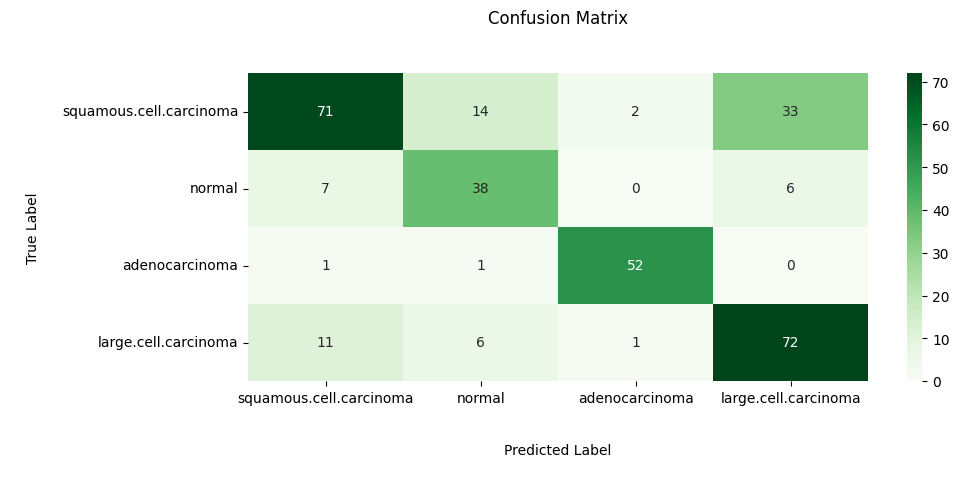

In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', xticklabels = test_c, yticklabels = test_c)
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

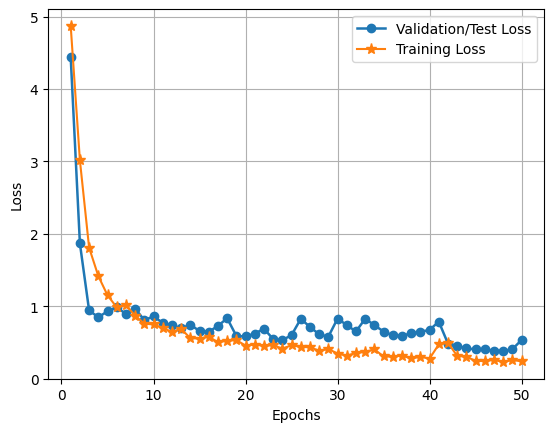

In [ ]:
#Plotting the loss charts

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.0)
plt.setp(line2, linewidth = 1.5, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

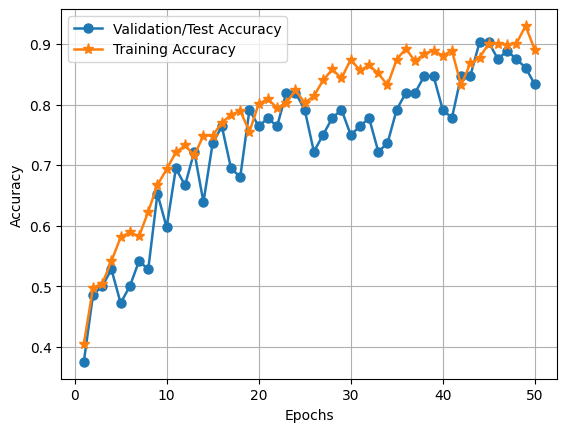

In [ ]:
#Plotting the accuracy charts
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1, linewidth = 1.8, marker = 'o', markersize = 6.5)
plt.setp(line2, linewidth = 1.8, marker = '*', markersize = 8.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()